In [1]:
# %tensorflow_version 2.x 
# On Colab, need this to specify tensorflow version
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from glob import glob
import time, gc, sys
import cv2

DATA_FOLDER = "../../data"
directory = "../tools"
sys.path.append(directory)
from helpers import (get_n, get_dummies, resize, plot_loss,
                     MultiOutputDataGenerator, plot_acc,
                    image_from_char)

In [2]:
import albumentations as A
def cutout_shiftscalerotate(image):
    if len(image.shape) > 2:
        width, height, _ = image.shape
    else:
        width, height = image.shape
    aug=A.Compose(
        [
#          A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, 
#         rotate_limit=8, border_mode=cv2.BORDER_REFLECT_101, p=0.6),
        A.Cutout(num_holes=1, max_h_size=width//2, max_w_size=height//2,
             fill_value=1.0, p=0.6)
        ]                     
        )
    image = aug(image=image)['image']
    return image
A.__version__

'0.4.3'

In [3]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, Activation, Concatenate
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.applications import DenseNet121, DenseNet169
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# tf.__version__

In [5]:
import os
for dirname, _, filenames in os.walk(DATA_FOLDER):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../../data/test_image_data_3.parquet
../../data/train.csv
../../data/test_image_data_1.parquet
../../data/train_image_data_2.parquet
../../data/train_image_data_3.parquet
../../data/test_image_data_2.parquet
../../data/test_image_data_0.parquet
../../data/train_image_data_0.parquet
../../data/class_map.csv
../../data/test.csv
../../data/train_image_data_1.parquet
../../data/sample_submission.csv
../../data/Kalpurush_Fonts/kalpurush-2.ttf


In [6]:
train_df_ = pd.read_csv(DATA_FOLDER+'/train.csv')
test_df_ = pd.read_csv(DATA_FOLDER + '/test.csv')
class_map_df = pd.read_csv(DATA_FOLDER + '/class_map.csv')
sample_sub_df = pd.read_csv(DATA_FOLDER + '/sample_submission.csv')

In [7]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

In [8]:
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [9]:
IMG_SIZE=128
# IMG_SIZE=64
N_CHANNELS=1

## Densenet


In [10]:
def build_densenet(SIZE, rate=0.3):
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, 1))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    # x = BatchNormalization(momentum=0.15)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate)(x)
#     x = Dense(256, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate)(x)
    x = Dense(512, activation='relu')(x)
    # x = BatchNormalization(momentum=0.15)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate)(x)

    # multi output
    grapheme_root = Dense(168, activation = 'softmax', name='root')(x)
    vowel_diacritic = Dense(11, activation = 'softmax', name='vowel')(x)
    consonant_diacritic = Dense(7, activation = 'softmax', name='consonant')(x)

    # model
    model = Model(inputs=input, outputs=[grapheme_root, vowel_diacritic, consonant_diacritic])
    
    return model

In [11]:
# opt = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9)
model = build_densenet(SIZE=IMG_SIZE, rate=0.5)
# model.compile(optimizer=opt, loss='categorical_crossentropy',  metrics=['accuracy'])
#               loss_weights=weights,)

In [12]:
# add l1 regularizer into layers 
regularizer = tf.keras.regularizers.l1(1e-3)
for layer in model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

# set the glorot_normal initializer
initializer = keras.initializers.glorot_normal(seed=None)
for layer in model.layers:
    for attr in ['kernel_initializer']:
        if hasattr(layer, attr):
            setattr(layer, attr, initializer)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 3)  30          input_2[0][0]                    
__________________________________________________________________________________________________
densenet121 (Model)             multiple             7037504     conv2d[0][0]                     
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1024)         0           densenet121[1][0]                
______________________________________________________________________________________________

In [15]:
weights = {'root': 0.4, 'vowel': 0.3, 'consonant':0.3}
# lr = 1e-3
# opt = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9)
model.compile(optimizer=Adam(lr=0.00016), loss='categorical_crossentropy', 
              loss_weights=weights, metrics=['accuracy'])

In [16]:
# Learning rate will be half after 3 epochs if accuracy is not increased
lr_scheduler = []
targets = ['root', 'vowel', 'consonant']
for target in targets:
    lr_scheduler.append(ReduceLROnPlateau(monitor=f'{target}_accuracy', 
                                            patience=3,
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001))

# Callback : Save best model
cp = ModelCheckpoint('saved_models/dense121_96x96_r.h5',
                           monitor = 'val_root_accuracy',
                           save_best_only = True,
                           save_weights_only = False,
                           mode = 'auto',
#                            save_freq = 1,
                           verbose = 0)
# Callback : Early Stop
es = EarlyStopping(monitor='val_root_accuracy',
                          mode = 'auto',
                          patience = 4,
                          min_delta = 0,
                          verbose = 1)

cb = [*lr_scheduler, cp]

In [17]:
# batch_size = 512
batch_size = 64
epochs = 30

In [18]:
HEIGHT = 137
WIDTH = 236

In [19]:
# model = keras.models.load_model("./saved_models/densenet121_64x64.h5")

In [ ]:
histories = []
# for i in range(4):
for i in [0,1]:
# for i in [2,3]:
    train_df = pd.merge(pd.read_parquet(DATA_FOLDER + f'/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)

    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train, size=IMG_SIZE, plain=False)/255

    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')


    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = \
    train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=6)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        preprocessing_function = cutout_shiftscalerotate
        )  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit(datagen.flow(x_train, {'root': y_train_root, 'vowel':y_train_vowel, 'consonant': y_train_consonant}, 
                                batch_size=batch_size),
                        epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                        steps_per_epoch=x_train.shape[0] // batch_size, 
                        callbacks=cb)
    #                           callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

    histories.append(history)

    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()


Training images: (50210, 128, 128, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'root': '...', 'vowel': '...', 'consonant': '...'}
    to  
  ['...', '...', '...']
Train for 721 steps, validate on 4017 samples
Epoch 1/30
721/721 [==============================] - 115s 160ms/step - loss: 3.2717 - root_loss: 5.7435 - vowel_loss: 1.7802 - consonant_loss: 1.4676 - root_accuracy: 0.0236 - vowel_accuracy: 0.4929 - consonant_accuracy: 0.5772 - val_loss: 1.9657 - val_root_loss: 4.1424 - val_vowel_loss: 0.5968 - val_consonant_loss: 0.4322 - val_root_accuracy: 0.1207 - val_vowel_accuracy: 0.8058 - val_consonant_accuracy: 0.8753
Epoch 2/30
721/721 [==============================] - 102s 142ms/step - loss: 2.0793 - root_loss: 4.1094 - vowel_loss: 0.8456 - consonant_loss: 0.6061 - root_accuracy: 0.1430 - vowel_accuracy: 0.7298 - consonant_accuracy: 0.8335 - val_loss: 1.1278 - val_root_loss: 2.3188 - val_vowel_loss: 0.4000 - val_

In [20]:
# model.save("./saved_models/densenet121_128x128_ensemble_final.h5")

In [21]:
model.save("./saved_models/densenet121_96x96_r_final.h5")

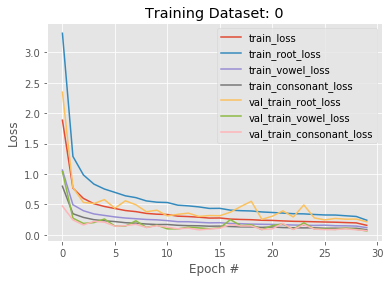

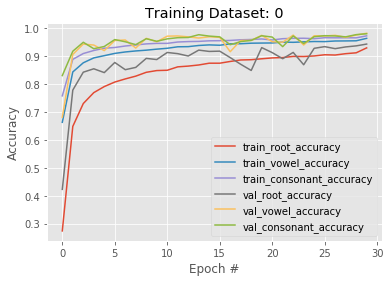

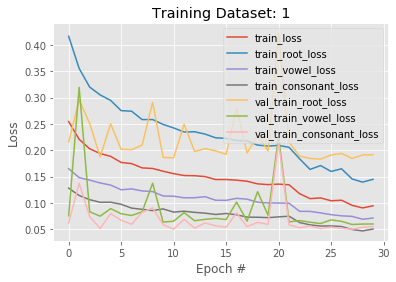

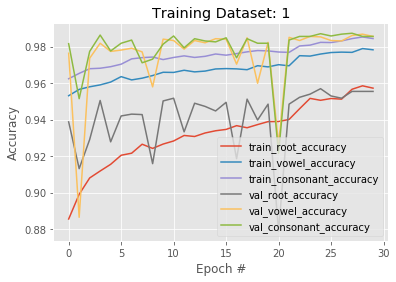

In [22]:
for dataset in range(2):
    plot_loss(histories[dataset], epochs, f'Training Dataset: {dataset}')
    plot_acc(histories[dataset], epochs, f'Training Dataset: {dataset}')

In [23]:
del histories
gc.collect()

15231

In [24]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [25]:
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(4):
    df_test_img = pd.read_parquet(DATA_FOLDER + f'/test_image_data_{i}.parquet') 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, size=IMG_SIZE, plain=False, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93


In [26]:
df_sample

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93
5,Test_1_vowel_diacritic,2
6,Test_2_consonant_diacritic,0
7,Test_2_grapheme_root,19
8,Test_2_vowel_diacritic,0
9,Test_3_consonant_diacritic,0
